# DEiT/CAiT Transformer Models Experimentation

In [4]:
import mlflow

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_addons as tfa

In [5]:
DATASET_SIZE = 9367
TRAIN_SIZE = 4447 
VAL_SIZE = 1112

IMAGE_SIZE = 224
BATCH_SIZE = 8
WORKERS = 4
EPOCHS = 10

BASE_PATH='../data'

classes = [
    'cup', 
    'fork', 
    'glass', 
    'knife', 
    'plate', 
    'spoon'
]

First, we will load the training dataframe and split it into train and validation

In [6]:
df_train_full = pd.read_csv('data/train.csv', dtype={'Id': str})
df_train_full['filename'] = 'data/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,data/images/0560.jpg
1,4675,cup,data/images/4675.jpg
2,0875,glass,data/images/0875.jpg
3,4436,spoon,data/images/4436.jpg
4,8265,plate,data/images/8265.jpg


In [7]:
val_cutoff = int(len(df_train_full) * 0.8)
df_train = df_train_full[:val_cutoff]
df_val = df_train_full[val_cutoff:]

Now let's create image generators

In [8]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
def get_datagen(params={}):
    
    image_size = params.get('image_size', IMAGE_SIZE)
    batch_size = params.get('batch_size', BATCH_SIZE)

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function = preprocess_input, 
        rotation_range=params.get('rotation_range', 0),
        width_shift_range=params.get('trans_width_range', 0.0),
        height_shift_range=params.get('trans_height_range', 0.0),
        shear_range=params.get('shear_range', 0.0),
        zoom_range=params.get('zoom_range', 0),
        horizontal_flip=params.get('horizontal_flip', False),
        vertical_flip=params.get('vertical_flip', False),
        dtype="float16"
    )

    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function = preprocess_input, 
        dtype="float16"
    )

    
    train_gen = train_datagen.flow_from_dataframe(
        df_train,
        x_col='filename',
        y_col='label',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        seed=0,
    )

    val_gen = val_datagen.flow_from_dataframe(
        df_val,
        x_col='filename',
        y_col='label',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        seed=0,
    )

    return train_gen, val_gen

In [10]:
train_generator, val_generator = get_datagen({})

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [11]:
classes = np.array(list(train_generator.class_indices.keys()))
classes

array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'], dtype='<U5')

In [12]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

callbacks = [earlystopping]

### DeiT w/ SGD Warmup

Code from Tensorflow Hub: https://github.com/sayakpaul/deit-tf

In [36]:
def get_model_deit(model_url, res=IMAGE_SIZE, num_classes=len(classes)) -> tf.keras.Model:
    inputs = tf.keras.Input((res, res, 3))
    hub_module = hub.KerasLayer(model_url, trainable=False)

    base_model_layers, _ = hub_module(inputs)   # Second output in the tuple is a dictionary containing attention scores.
    outputs = keras.layers.Dense(num_classes, activation="softmax")(base_model_layers)

    # flatten         = tf.keras.layers.Flatten()(base_model_layers)
    # batch_norm_1    = tf.keras.layers.BatchNormalization()(flatten)
    # dense           = tf.keras.layers.Dense(12, 'gelu')(batch_norm_1)
    # batch_norm_2    = tf.keras.layers.BatchNormalization()(dense)
    # outputs         = tf.keras.layers.Dense(6, 'softmax')(batch_norm_2)
    
    return tf.keras.Model(inputs, outputs) 

In [14]:
model_gcs_path = "http://tfhub.dev/sayakpaul/deit_base_distilled_patch16_224_fe/1"
model = get_model_deit(model_gcs_path)

In [15]:
# Reference:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

SGD w/ Warmup:

In [16]:
EPOCHS = 10
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006

TOTAL_STEPS = int((TRAIN_SIZE / BATCH_SIZE) * EPOCHS)

In [17]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

# lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
# plt.figure(figsize=(10, 6))
# plt.plot(lrs)
# plt.xlabel("Step", fontsize=14)
# plt.ylabel("LR", fontsize=14)
# plt.show()


In [17]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.SGD(scheduled_lrs)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [18]:
history = model.fit(
    x = train_generator,
    validation_data=val_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    workers=WORKERS,
    callbacks=callbacks
)

Epoch 1/10
556/556 [==============================] - 104s 158ms/step - loss: 0.2603 - accuracy: 0.9226 - val_loss: 0.1191 - val_accuracy: 0.9631
Epoch 2/10
556/556 [==============================] - 45s 80ms/step - loss: 0.0993 - accuracy: 0.9685 - val_loss: 0.1057 - val_accuracy: 0.9703
Epoch 3/10
556/556 [==============================] - 45s 80ms/step - loss: 0.0785 - accuracy: 0.9755 - val_loss: 0.1234 - val_accuracy: 0.9613
Epoch 4/10
556/556 [==============================] - 45s 80ms/step - loss: 0.0596 - accuracy: 0.9831 - val_loss: 0.1368 - val_accuracy: 0.9577
Epoch 5/10
556/556 [==============================] - 45s 80ms/step - loss: 0.0504 - accuracy: 0.9879 - val_loss: 0.0976 - val_accuracy: 0.9694
Epoch 6/10
556/556 [==============================] - 45s 80ms/step - loss: 0.0432 - accuracy: 0.9908 - val_loss: 0.1011 - val_accuracy: 0.9676
Epoch 7/10
556/556 [==============================] - 45s 81ms/step - loss: 0.0394 - accuracy: 0.9915 - val_loss: 0.1007 - val_accurac

Adam:

In [18]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [19]:
history = model.fit(
    x = train_generator,
    validation_data=val_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    workers=WORKERS,
    callbacks=callbacks
)

Epoch 1/10
556/556 [==============================] - 60s 88ms/step - loss: 0.3032 - accuracy: 0.9337 - val_loss: 0.2568 - val_accuracy: 0.9604
Epoch 2/10
556/556 [==============================] - 49s 89ms/step - loss: 0.1484 - accuracy: 0.9712 - val_loss: 0.3433 - val_accuracy: 0.9568
Epoch 3/10
556/556 [==============================] - 45s 81ms/step - loss: 0.1254 - accuracy: 0.9771 - val_loss: 0.3304 - val_accuracy: 0.9496
Epoch 4/10
556/556 [==============================] - 45s 81ms/step - loss: 0.1128 - accuracy: 0.9807 - val_loss: 0.3048 - val_accuracy: 0.9649
Epoch 5/10
556/556 [==============================] - 45s 81ms/step - loss: 0.1237 - accuracy: 0.9795 - val_loss: 0.3493 - val_accuracy: 0.9550
Epoch 6/10
556/556 [==============================] - 45s 81ms/step - loss: 0.0915 - accuracy: 0.9829 - val_loss: 0.3968 - val_accuracy: 0.9595
Epoch 7/10
556/556 [==============================] - 45s 81ms/step - loss: 0.0486 - accuracy: 0.9908 - val_loss: 0.4553 - val_accuracy:

### CAiT w/ AdamW:

Code from Tensorflow Hub: https://github.com/sayakpaul/cait-tf

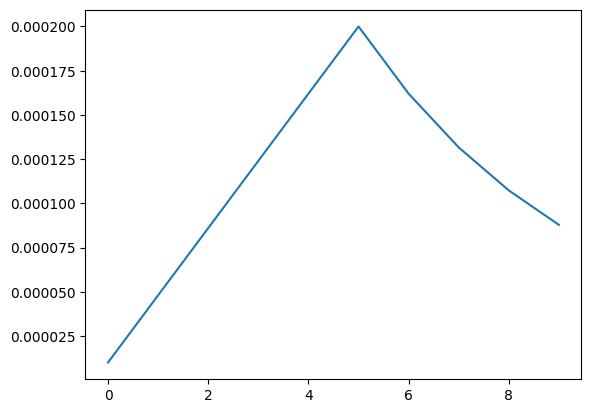

In [29]:
EPOCHS = 10

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.0002
rampup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8


def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr) / rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay ** (
                epoch - rampup_epochs - sustain_epochs
            ) + min_lr
        return lr

    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)


lr_callback = keras.callbacks.LearningRateScheduler(
    lambda epoch: lrfn(epoch), verbose=True
)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
plt.show()

In [37]:
model_gcs_path = "https://tfhub.dev/sayakpaul/cait_xxs36_224_fe/1"  
model = get_model_cait(model_gcs_path, res=224)

In [38]:
optimizer = tfa.optimizers.AdamW(weight_decay=1e-5)
loss = keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [39]:
callbacks.append(lr_callback)

In [40]:
history = model.fit(
    x = train_generator,
    validation_data=val_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    workers=WORKERS,
    callbacks=callbacks
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/10
556/556 [==============================] - 197s 281ms/step - loss: 0.3319 - accuracy: 0.8871 - val_loss: 0.1320 - val_accuracy: 0.9613 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.8e-05.

Epoch 2: LearningRateScheduler setting learning rate to 4.8e-05.
Epoch 2/10
556/556 [==============================] - 148s 266ms/step - loss: 0.1065 - accuracy: 0.9660 - val_loss: 0.1401 - val_accuracy: 0.9568 - lr: 4.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 8.6e-05.

Epoch 3: LearningRateScheduler setting learning rate to 8.6e-05.
Epoch 3/10
556/556 [==============================] - 150s 270ms/step - loss: 0.1166 - accuracy: 0.9656 - val_loss: 0.1856 - val_accuracy: 0.9478 - lr: 8.6000e-05

Epoch 4: LearningRateScheduler setting learning rate to 0.000124.

Epoch 4: LearningRateScheduler setting learning rat